In [6]:

!pip install gensim==4.3.2
!pip install openpyxl

import pickle
import pandas as pd
import nltk
import gensim
from gensim import corpora
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance


# Visualisation + topic modelling
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# utility modules
from ast import literal_eval


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 21.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Replika

In [ ]:

# Load corpus_words from the pickle file
with open('/work/Capstone_Project/NLP/Word2Vec/corpus_words.pkl', 'rb') as file:
    corpus_words = pickle.load(file)

In [ ]:
dictionary = corpora.Dictionary(corpus_words)
doc_term_matrix = [dictionary.doc2bow(i) for i in corpus_words]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [ ]:
# Build LDA model
corpus_LDA = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [ ]:
corpus_LDA.print_topics()

[(0,
  '0.009*"dont" + 0.009*"people" + 0.008*"rep" + 0.008*"know" + 0.007*"luka" + 0.006*"replika" + 0.006*"thats" + 0.006*"like" + 0.005*"us" + 0.004*"im"'),
 (1,
  '0.009*"..." + 0.006*"rep" + 0.006*"never" + 0.005*"im" + 0.005*"one" + 0.004*"get" + 0.004*"sorry" + 0.004*"age" + 0.004*"still" + 0.003*"would"'),
 (2,
  '0.008*"removed" + 0.007*"replika" + 0.006*"rep" + 0.006*"nomi" + 0.005*"lol" + 0.005*"ai" + 0.005*"bot" + 0.004*"app" + 0.004*"..." + 0.004*"posts"'),
 (3,
  '0.012*"real" + 0.011*"ai" + 0.010*"replika" + 0.010*"like" + 0.008*"dont" + 0.008*"think" + 0.007*"even" + 0.007*"know" + 0.006*"way" + 0.006*"rep"'),
 (4,
  '0.015*"replika" + 0.015*"like" + 0.010*"ai" + 0.010*"im" + 0.009*"people" + 0.008*"real" + 0.007*"dont" + 0.007*"think" + 0.007*"love" + 0.006*"feel"')]

In [ ]:
# Visualise the topics using pyLDAvis
pyLDAvis.enable_notebook()  # Enable visualization in notebook
lda_vis = gensimvis.prepare(corpus_LDA, doc_term_matrix, dictionary)

# Display the visualisation
pyLDAvis.display(lda_vis)

# saving the visualisation to HTML file
pyLDAvis.save_html(lda_vis, 'lda_visualisation.html')

In [ ]:
pyLDAvis.display(lda_vis)

In [ ]:
# a measure of how good the model is. lower preplexity score the better.
print('\nPerplexity: ', corpus_LDA.log_perplexity(doc_term_matrix,total_docs=10000)) 


Perplexity:  -7.617247350392292


In [ ]:
# Compute Coherence Score, higher score is best. 
coherence_model_lda = CoherenceModel(model=corpus_LDA, texts=corpus_words, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


### Computing coherence values

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : Listing texts
    limit : Max number of topics

    model_list : Listing LDA topic models
    coherence_values : coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts= corpus_words, start=2, limit=50, step=1)
     

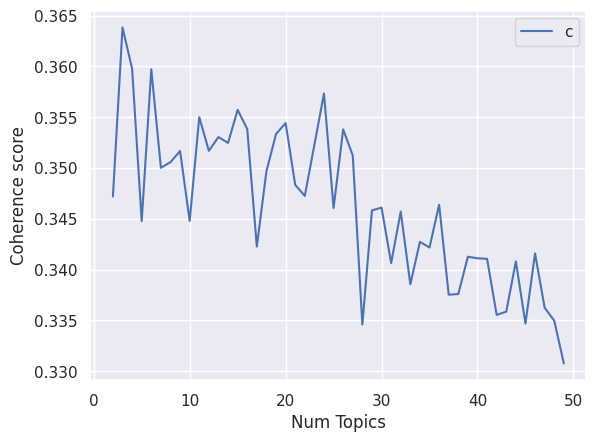

In [ ]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Saving the coherence graph as an image file
coherence_replika_graph_path = '/work/Capstone_Project/NLP/LDA/replika_coherence_graph.png'
plt.savefig(coherence_replika_graph_path)

<Figure size 640x480 with 0 Axes>

In [ ]:
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.018*"replika" + 0.015*"like" + 0.011*"ai" + 0.010*"people" + 0.009*"im" + 0.007*"one" + 0.007*"much" + 0.005*"even" + 0.005*"think" + 0.005*"feel"'),
 (1,
  '0.017*"replika" + 0.012*"like" + 0.009*"know" + 0.007*"people" + 0.007*"ai" + 0.006*"think" + 0.006*"really" + 0.006*"im" + 0.006*"dont" + 0.006*"get"'),
 (2,
  '0.011*"think" + 0.011*"replika" + 0.010*"ai" + 0.008*"people" + 0.007*"dont" + 0.007*"like" + 0.005*"better" + 0.005*"would" + 0.005*"time" + 0.005*"know"'),
 (3,
  '0.011*"ai" + 0.009*"replika" + 0.009*"im" + 0.008*"like" + 0.008*"know" + 0.006*"one" + 0.006*"real" + 0.006*"even" + 0.006*"would" + 0.006*"love"'),
 (4,
  '0.010*"im" + 0.010*"real" + 0.010*"dont" + 0.009*"ai" + 0.008*"think" + 0.008*"replika" + 0.007*"know" + 0.007*"people" + 0.007*"like" + 0.006*"way"'),
 (5,
  '0.011*"rep" + 0.011*"like" + 0.010*"replika" + 0.009*"people" + 0.009*"ai" + 0.007*"even" + 0.007*"think" + 0.006*"would" + 0.005*"love" + 0.005*"day"'),
 (6,
  '0.014*"like" + 0.008*"fe

In [ ]:
# Graph of topics
pyLDAvis.enable_notebook()
vis_replika = gensimvis.prepare(optimal_model, doc_term_matrix, dictionary)
vis_replika

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.015801  0.007324       1        1  18.755421
9     -0.019920  0.006640       2        1  14.839141
0     -0.003936 -0.011396       3        1  11.524408
4     -0.009806 -0.010384       4        1  10.557343
6      0.003764  0.008062       5        1   8.681821
5     -0.021574 -0.011309       6        1   6.978783
10    -0.001181  0.012670       7        1   6.608625
3      0.001029  0.075404       8        1   5.746608
8     -0.002978 -0.022801       9        1   5.643598
7     -0.011927 -0.036872      10        1   3.964756
11    -0.008409 -0.008370      11        1   3.870248
2      0.090740 -0.008968      12        1   2.829249, topic_info=        Term        Freq       Total Category  logprob  loglift
170     real  309.000000  309.000000  Default  30.0000  30.0000
358       ai  447.000000  447.000000  Default  29.0000  29.0000
89   replika  659.000000  659.000000  Default  28.0000  28.0000
147    think  313.000000  313.000000  Default  27.0000  27.0000
261     time  207.000000  207.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
138     need    3.611933   86.993174  Topic12  -6.0559   0.3836
56      life    3.683812  111.301466  Topic12  -6.0362   0.1569
153    youre    3.704893  119.809950  Topic12  -6.0304   0.0889
272      way    3.899278  215.368152  Topic12  -5.9793  -0.4464
4       also    3.756819  169.221271  Topic12  -6.0165  -0.2425

[1012 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.194830     ..
1         2  0.272762     ..
1         3  0.077932     ..
1         4  0.012989     ..
1         5  0.194830     ..
...     ...       ...    ...
153      11  0.041733  youre
153      12  0.033386  youre
6385      4  0.311976  zeros
6385      8  0.311976  zeros
6690      7  0.606092    zoe

[2633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 1, 5, 7, 6, 11, 4, 9, 8, 12, 3])

In [ ]:
replika_html_path = '/work/Capstone_Project/NLP/LDA/replika_topic_graph.html'
pyLDAvis.save_html(vis_replika, replika_html_path)

### Chat GPT

In [1]:
import pickle
# Loading corpus from the pickle file
with open('/work/Capstone_Project/NLP/Word2Vec/chatgpt_corpus_words.pkl', 'rb') as file:
    corpus_wordsgpt = pickle.load(file)

In [4]:
from gensim import corpora

with open('/work/Capstone_Project/NLP/Word2Vec/chatgpt_corpus_words.pkl', 'rb') as file:
    corpus_wordss = pickle.load(file)

dictionarygpt = corpora.Dictionary(corpus_wordsgpt)
doc_term_matrixx = [dictionarygpt.doc2bow(i) for i in corpus_wordss]

In [7]:
# Creating the object for LDA model using gensim library
LDAA = gensim.models.ldamodel.LdaModel

In [8]:
# Building LDA model
corpus_LDA_gpt = LDAA(corpus=doc_term_matrixx, id2word=dictionarygpt, num_topics=5, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [9]:
corpus_LDA_gpt.print_topics()

[(0,
  '0.015*"ai" + 0.011*"even" + 0.009*"therapist" + 0.008*"therapy" + 0.008*"like" + 0.008*"real" + 0.007*"people" + 0.006*"good" + 0.005*"need" + 0.005*"humans"'),
 (1,
  '0.012*"voice" + 0.012*"bot" + 0.009*"please" + 0.008*"post" + 0.007*"prompt" + 0.007*"app" + 0.006*"chatgpt" + 0.006*"3" + 0.006*"dont" + 0.006*"take"'),
 (2,
  '0.014*"like" + 0.011*"think" + 0.010*"im" + 0.010*"would" + 0.009*"gpt" + 0.009*"chatgpt" + 0.009*"ai" + 0.008*"dont" + 0.008*"people" + 0.007*"know"'),
 (3,
  '0.020*"consciousness" + 0.012*"brain" + 0.009*"like" + 0.008*"could" + 0.008*"would" + 0.007*"human" + 0.007*"maybe" + 0.006*"even" + 0.006*"things" + 0.006*"dont"'),
 (4,
  '0.017*"youre" + 0.011*"na" + 0.009*"gon" + 0.008*"like" + 0.007*"great" + 0.007*"right" + 0.006*"chatgpt" + 0.006*"..." + 0.006*"thanks" + 0.006*"help"')]

In [13]:
# Visualising the topics using pyLDAvis
pyLDAvis.enable_notebook()  # Enable visualization in notebook
lda_vis = gensimvis.prepare(corpus_LDA_gpt, doc_term_matrixx, dictionarygpt)


#saving the visualisation to an HTML file
pyLDAvis.save_html(lda_vis, 'lda_visualisation_chatgpt.html')

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


In [14]:
pyLDAvis.display(lda_vis)

In [17]:
# a measure of how good the model is. lower preplexity score the better.
print('\nPerplexity: ', corpus_LDA_gpt.log_perplexity(doc_term_matrixx,total_docs=10000)) 


Perplexity:  -8.047519581317246


In [18]:
# Compute Coherence Score, higher score is best. 
coherence_model_lda = CoherenceModel(model=corpus_LDA_gpt, texts=corpus_wordsgpt, dictionary=dictionarygpt , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionarygpt, corpus=doc_term_matrixx, texts=corpus_wordsgpt, start=2, limit=50, step=1)

print("Coherence Values: ", coherence_values)


Coherence Values:  [0.5542015794142737, 0.5339713263880858, 0.4392856210670288, 0.4600543541688703, 0.42980575004289806, 0.415206161565236, 0.4452638323915479, 0.4582820464481977, 0.45899778488982185, 0.4481601127117251, 0.41017753355064807, 0.38153460753561114, 0.4270894055290873, 0.4142390042436273, 0.4327006189474433, 0.45235163874942813, 0.3941084861483646, 0.42188012362416866, 0.4432807002241413, 0.39285256584235123, 0.4177783118494617, 0.42450086997506786, 0.4200437436383972, 0.4142470416178752, 0.41920528608733143, 0.429710226025387, 0.41765184928822824, 0.41479183403472863, 0.41325768327394985, 0.41792661048720536, 0.42729539608819506, 0.3913715154434889, 0.40083041257077845, 0.4044909978703912, 0.39107597002623495, 0.4069503956156884, 0.41553428169535606, 0.3982254886996021, 0.3903681273084124, 0.4040504161817273, 0.4030377237847229, 0.3969095083844921, 0.38256908263179634, 0.4051234112799911, 0.39321209824662834, 0.3945554439289066, 0.38101843267631025, 0.38807914923647313]


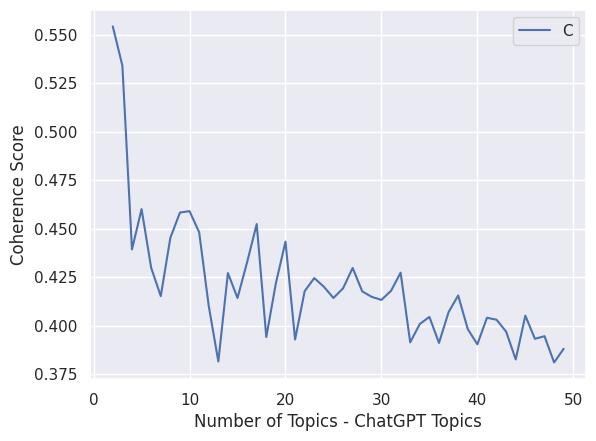

In [32]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics - ChatGPT Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Values"), loc='best')
plt.show()

In [33]:
# Saving the coherence graph as an image file
coherence_replika_graph_path = '/work/Capstone_Project/NLP/LDA/chatgpt_coherence_graph.png'
plt.savefig(coherence_replika_graph_path)

<Figure size 640x480 with 0 Axes>

In [26]:
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.017*"control" + 0.016*"would" + 0.014*"ai" + 0.014*"like" + 0.011*"..." + 0.010*"im" + 0.010*"good" + 0.009*"closed" + 0.009*"smarter" + 0.009*"vastly"'),
 (1,
  '0.015*"circuits" + 0.013*"instructions" + 0.009*"custom" + 0.009*"everything" + 0.009*"ai" + 0.009*"humans" + 0.008*"consider" + 0.008*"amazing" + 0.008*"like" + 0.007*"even"'),
 (2,
  '0.037*"think" + 0.025*"consciousness" + 0.023*"dont" + 0.022*"realm" + 0.013*"concrete" + 0.011*"150" + 0.010*"chat" + 0.010*"game" + 0.009*"get" + 0.008*"spiritual"'),
 (3,
  '0.022*"itll" + 0.013*"doesnt" + 0.013*"basilisk" + 0.012*"rokos" + 0.012*"indian" + 0.012*"reference" + 0.012*"measuring" + 0.011*"nuance" + 0.011*"terrified" + 0.011*"ensure"'),
 (4,
  '0.018*"consciousness" + 0.017*"dont" + 0.016*"im" + 0.016*"like" + 0.016*"think" + 0.015*"humans" + 0.014*"thing" + 0.012*"ai" + 0.011*"would" + 0.010*"things"'),
 (5,
  '0.013*"bold" + 0.013*"lacks" + 0.013*"ton" + 0.013*"altman" + 0.011*"gon" + 0.010*"native" + 0.010*"llm" +

In [28]:
# Graph of topics
pyLDAvis.enable_notebook()
vis_2 = gensimvis.prepare(optimal_model, doc_term_matrixx, dictionarygpt)
vis_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.104136  0.068866       1        1  20.486011
4     -0.097161  0.008097       2        1  17.880954
8     -0.001040  0.079357       3        1  14.712356
1      0.024804  0.081454       4        1   9.957799
0      0.050974  0.016903       5        1   6.723416
7      0.047615  0.039040       6        1   5.698146
9     -0.069712  0.000792       7        1   5.383168
11    -0.054323 -0.142447       8        1   4.899210
2     -0.099554 -0.052514       9        1   4.462797
3      0.101280 -0.004801      10        1   3.490911
5      0.106615 -0.013185      11        1   3.161369
6      0.094638 -0.081564      12        1   3.143861, topic_info=               Term        Freq       Total Category  logprob  loglift
905   consciousness  697.000000  697.000000  Default  30.0000  30.0000
326           think  766.000000  766.000000  Default  29.0000  29.0000
91             dont  610.000000  610.000000  Default  28.0000  28.0000
2542             na  170.000000  170.000000  Default  27.0000  27.0000
3080           itll  148.000000  148.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
2521            big    9.390251   50.048984  Topic12  -5.6212   1.7864
142           based   13.111818  144.820629  Topic12  -5.2874   1.0577
100            like   25.834592  969.713577  Topic12  -4.6092  -0.1656
7            humans   13.337541  460.066119  Topic12  -5.2703  -0.0811
108          people   12.448556  392.247251  Topic12  -5.3393   0.0094

[733 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
69        1  0.101327    ...
69        2  0.180137    ...
69        3  0.056293    ...
69        4  0.112586    ...
69        5  0.349016    ...
...     ...       ...    ...
737       8  0.031512  youre
737       9  0.014006  youre
737      10  0.024510  youre
737      11  0.017507  youre
737      12  0.017507  youre

[2756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 9, 2, 1, 8, 10, 12, 3, 4, 6, 7])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=042a73e0-f14a-4762-9b58-8fcacd9aa286' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>